<a href="https://colab.research.google.com/github/StudentsAntoniPartyka/ML/blob/main/pd10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
Task 1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Load MNIST dataset (training and test sets)
transform = transforms.ToTensor()
train_set = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_set  = datasets.MNIST(root="./data", train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_set, batch_size=64)

# Define LeNet-5 model
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)   # 28x28 -> 24x24x6
        self.pool1 = nn.AvgPool2d(kernel_size=2)      # 24x24x6 -> 12x12x6
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)  # 12x12x6 -> 8x8x16
        self.pool2 = nn.AvgPool2d(kernel_size=2)      # 8x8x16 -> 4x4x16
        self.fc1   = nn.Linear(16*4*4, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = self.pool1(x)
        x = torch.tanh(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return self.fc3(x)  # outputs raw scores (logits)

# Initialize model and optimizer
model = LeNet5()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train the model (skip training if already trained and saved)
NUM_EPOCHS = 3
for epoch in range(1, NUM_EPOCHS+1):
    model.train()
    total_loss, correct = 0.0, 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(dim=1) == labels).sum().item()
    avg_loss = total_loss / len(train_set)
    accuracy = correct / len(train_set)
    print(f"Epoch {epoch}: Train loss = {avg_loss:.4f}, Train accuracy = {accuracy*100:.2f}%")

# Evaluate on test set
model.eval()
correct = 0
for images, labels in test_loader:
    outputs = model(images)
    preds = outputs.argmax(dim=1)
    correct += (preds == labels).sum().item()
test_acc = correct / len(test_set)
print(f"Test Accuracy: {test_acc*100:.2f}%")


100%|██████████| 9.91M/9.91M [00:02<00:00, 3.44MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 345kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.49MB/s]


Epoch 1: Train loss = 0.3128, Train accuracy = 90.91%
Epoch 2: Train loss = 0.0981, Train accuracy = 96.98%
Epoch 3: Train loss = 0.0658, Train accuracy = 97.92%
Test Accuracy: 98.19%


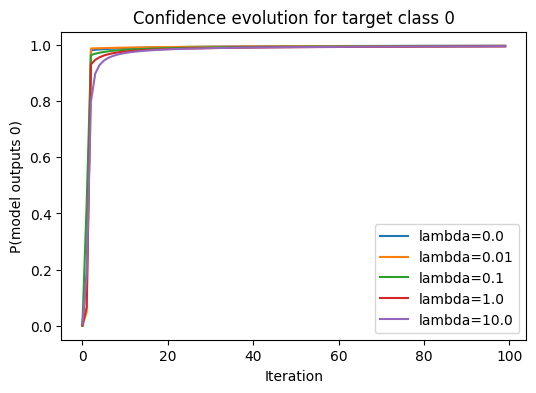

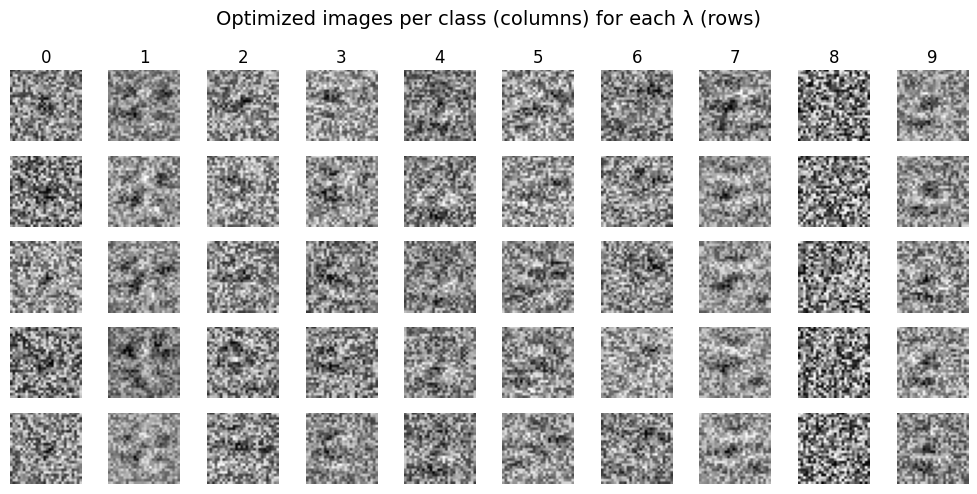

In [2]:
import matplotlib.pyplot as plt

# Function to generate a "dream" image for a given target class and lambda
def generate_dream(target_label, lambda_l2, steps=100, lr=0.1):
    # start from random noise image
    image = torch.rand((1, 1, 28, 28), requires_grad=True)
    optimizer_img = torch.optim.SGD([image], lr=lr)
    confidences = []
    for step in range(steps):
        optimizer_img.zero_grad()
        output = model(image)
        loss = F.cross_entropy(output, torch.tensor([target_label])) + lambda_l2 * image.pow(2).mean()
        loss.backward()
        optimizer_img.step()
        # Record confidence (predicted probability of target class) for analysis
        prob = F.softmax(output, dim=1)[0, target_label].item()
        confidences.append(prob)
    return image.detach(), confidences

# Generate dream images for each lambda
lambdas = [0.0, 0.01, 0.1, 1.0, 10.0]
dreams_per_lambda = {lam: [] for lam in lambdas}
conf_curves = {lam: None for lam in lambdas}

for lam in lambdas:
    # For one lambda, generate images for all 10 classes
    for digit in range(10):
        img, conf = generate_dream(target_label=digit, lambda_l2=lam, steps=100)
        dreams_per_lambda[lam].append(img.squeeze().numpy())  # 28x28 image array
        # If this is digit 0, store the confidence curve for plotting
        if digit == 0:
            conf_curves[lam] = conf

# Plot confidence evolution for class '0' under different lambdas
plt.figure(figsize=(6,4))
for lam, conf in conf_curves.items():
    plt.plot(conf, label=f"lambda={lam}")
plt.title("Confidence evolution for target class 0")
plt.xlabel("Iteration")
plt.ylabel("P(model outputs 0)")
plt.legend()
plt.show()

# Visualize the optimized images for each lambda
fig, axes = plt.subplots(len(lambdas), 10, figsize=(10, 5))
for row, lam in enumerate(lambdas):
    for col in range(10):
        axes[row, col].imshow(dreams_per_lambda[lam][col], cmap='gray')
        axes[row, col].axis('off')
        if col == 0:
            axes[row, col].set_ylabel(f"λ={lam}", rotation=0, labelpad=20, size=12)
        if row == 0:
            axes[row, col].set_title(str(col), fontsize=12)
plt.suptitle("Optimized images per class (columns) for each λ (rows)", fontsize=14)
plt.tight_layout()
plt.show()


Task 2

In [3]:
import numpy as np

lambda_l2 = 0.1
targets = []    # to store target labels for each image
orig_labels = []
orig_images = []
adv_images = []

# Select 9 images per class from the test set
test_by_class = {i: [] for i in range(10)}
for img, label in test_set:
    if len(test_by_class[label]) < 9:  # take at most 9 per class
        test_by_class[label].append(img)
# Flatten selected images and true labels
for true_label, imgs in test_by_class.items():
    for img in imgs:
        orig_images.append(img)
        orig_labels.append(true_label)
        targets.append((true_label + 1) % 10)  # target label (wrong class)

# Perform adversarial attack on each selected image
adv_success = 0
adv_deltas = []
for img_tensor, true_label, target_label in zip(orig_images, orig_labels, targets):
    x = img_tensor.unsqueeze(0)  # shape [1,1,28,28]
    # initialize small random delta (or zeros)
    delta = torch.zeros_like(x, requires_grad=True)
    optimizer_delta = torch.optim.SGD([delta], lr=0.05)
    for step in range(50):
        optimizer_delta.zero_grad()
        output = model(x + delta)
        loss = F.cross_entropy(output, torch.tensor([target_label])) + lambda_l2 * (delta.pow(2).mean())
        loss.backward()
        optimizer_delta.step()
    # clamp the perturbed image to [0,1]
    perturbed = (x + delta).detach()
    perturbed.clamp_(0, 1)
    adv_images.append(perturbed.squeeze().numpy())
    # Check success
    pred_label = model(perturbed).argmax(dim=1).item()
    if pred_label == target_label:
        adv_success += 1

print(f"Attack success rate: {adv_success}/{len(orig_images)} = {adv_success/len(orig_images)*100:.1f}%")


Attack success rate: 43/90 = 47.8%


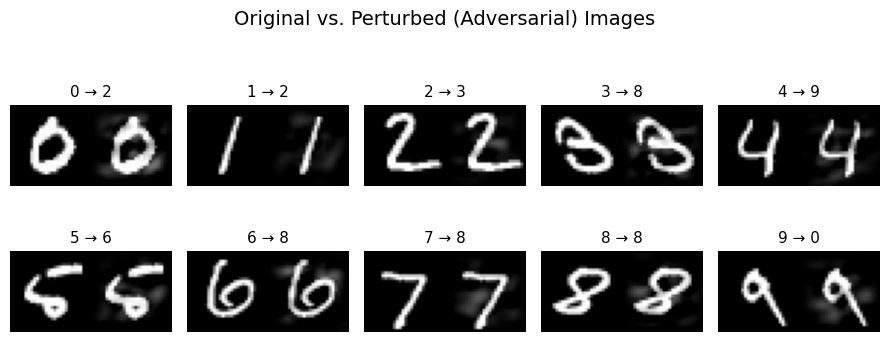

In [5]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 4))
rows, cols = 2, 5
shown = [False]*10
plot_index = 1

for orig_img, adv_img, true_label, target_label in zip(orig_images, adv_images, orig_labels, targets):
    # original prediction (orig_img has shape [1,28,28])
    pred_orig = model(orig_img.unsqueeze(0)).argmax(dim=1).item()

    # build a proper tensor for adv_img: add batch and channel dims
    adv_tensor = torch.tensor(adv_img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    pred_adv  = model(adv_tensor).argmax(dim=1).item()

    if plot_index <= rows*cols and not shown[true_label]:
        plt.subplot(rows, cols, plot_index)
        pair = np.concatenate([orig_img.squeeze().numpy(), adv_img], axis=1)
        plt.imshow(pair, cmap='gray')
        plt.axis('off')
        plt.title(f"{true_label} → {pred_adv}", fontsize=11)
        shown[true_label] = True
        plot_index += 1

plt.suptitle("Original vs. Perturbed (Adversarial) Images", fontsize=14)
plt.tight_layout()
plt.show()

